# ECG Beat Segmentation, Normalization, and Labeling Pipeline

This notebook presents a comprehensive pipeline for the segmentation, normalization, and labeling of ECG signals using the PTB-XL dataset. The workflow includes data preprocessing, beat-wise segmentation, per-beat normalization, assignment of multilabel targets, dataset partitioning (train, validation, and test), exploratory visualization, and figure exportation for use in deep learning frameworks (e.g., CNN/LSTM). The procedures are documented in academic English, with an emphasis on reproducibility and clarity.

---


Import Lib

In [7]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

from scipy.signal import find_peaks, butter, filtfilt
from sklearn.model_selection import train_test_split


sns.set_style('darkgrid')
folder = 'gambar_data'  # output folder (modify the path as needed)
os.makedirs(folder, exist_ok=True)

Superclasses enumerated by dataset description are as follows:
```
Records | Superclass | Description
9528 | NORM | Normal ECG (NORM)
5486 | MI | Myocardial Infarction (MI)
5250 | STTC | ST/T Change (STTC)
4907 | CD | Conduction Disturbance (CD)
2655 | HYP | Hypertrophy (HYP)
```

In [8]:
import torch
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Read Data

In [10]:
PATH_TO_DATA = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709,56.0,1,NaN,63.0,2,0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [11]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)
                    
ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

In [12]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

ECG_data.shape

(21837, 1000, 12)

Visualize all data and partition data

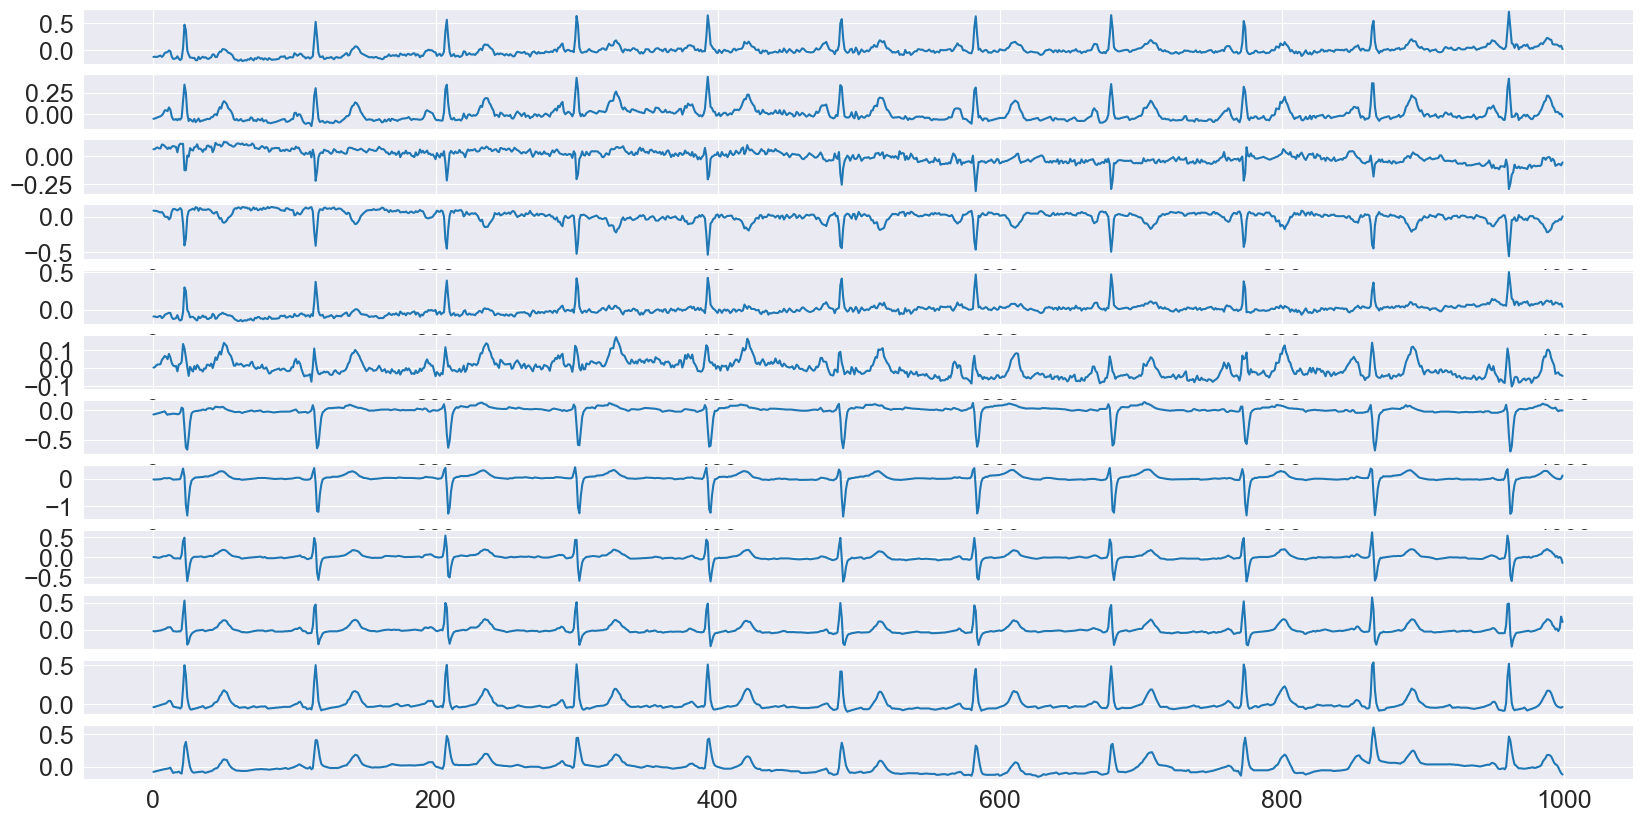

In [25]:
sample = ECG_data[0]  # Pastikan ECG_data sudah ada dalam lingkungan Anda
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20, 10))

for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])

# Perbesar angka pada sumbu X dan Y
for ax in axes:
    ax.tick_params(axis='both', labelsize=18)  # Mengatur ukuran font for sumbu X dan Y

plt.savefig(os.path.join(folder, "Data Visualize"))
plt.show()
plt.close()


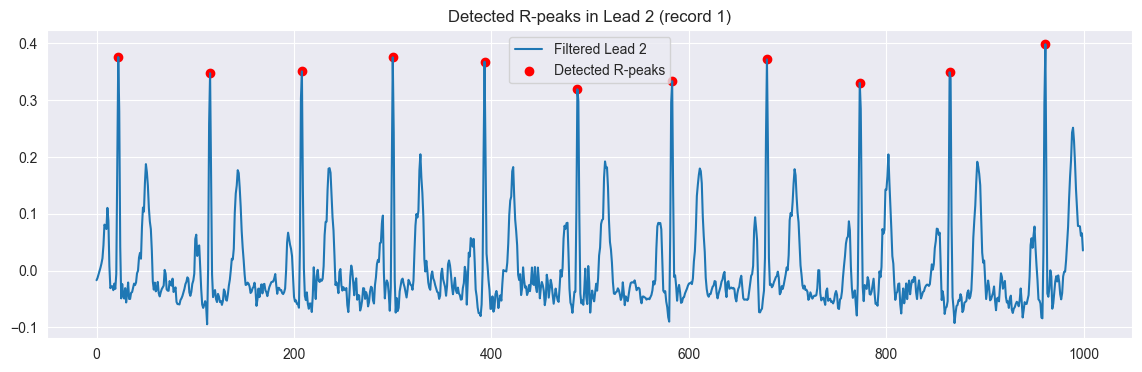

Total R-peaks: 11, Beats disimpan: 10, Beats di-skip: 1


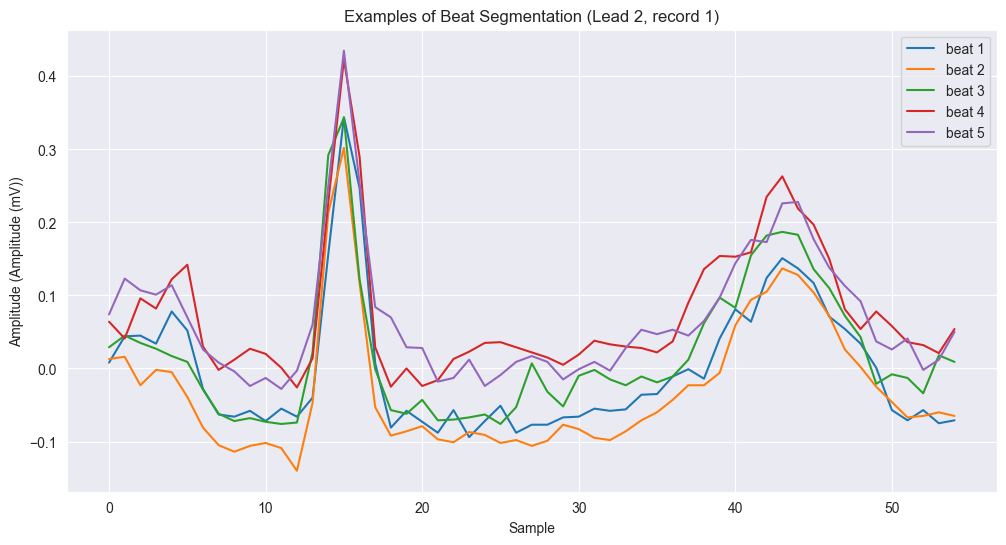

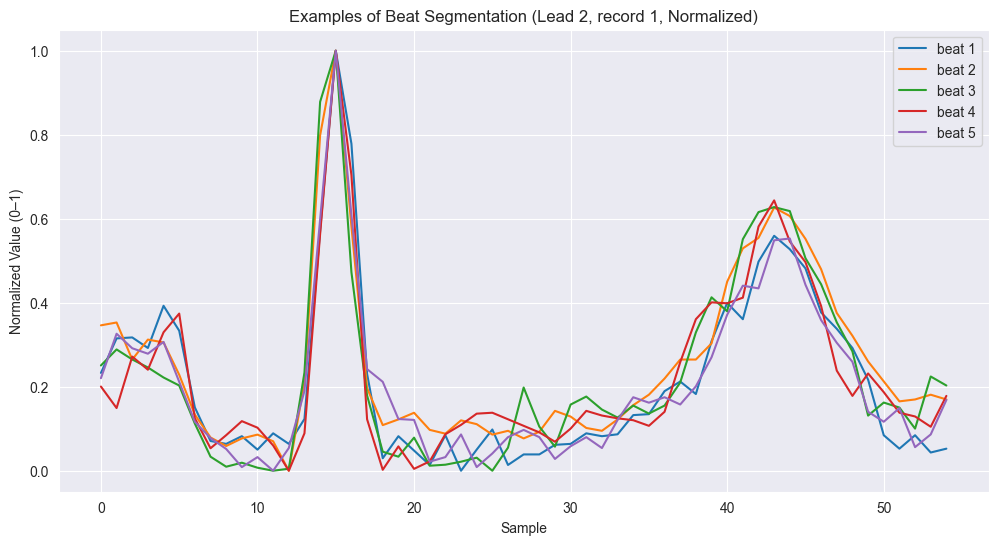

Beat 1 shape: (55, 12)
Beat 2 shape: (55, 12)
Beat 3 shape: (55, 12)
Beat 4 shape: (55, 12)
Beat 5 shape: (55, 12)


In [27]:
# ===========================
# PARAMETER DINAMIS
# ===========================
sig = 0   # Indeks record/data yang ingin dilihat
lead = 1  # Indeks lead yang ingin diDisplay (0 = lead 1, 1 = lead 2, dst.)

fs = 100
pre = int(0.15 * fs)   # window sebelum R-peak (dalam sample)
post = int(0.4 * fs)   # window setelah R-peak (dalam sample)
expected_len = pre + post

# ===========================
# Bandpass filter function
# ===========================
def bandpass_filter(signal, fs, low=0.5, high=40):
    b, a = butter(2, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, signal)

# ===========================
# Signal extraction and filtering
# ===========================
signal = ECG_data[sig][:, lead]
filtered_signal = bandpass_filter(signal, fs)

# ===========================
# R-peak detection (using find_peaks with adaptive threshold)
# ===========================
height_thresh = np.percentile(filtered_signal, 99) * 0.6
distance = int(0.5 * fs)
peaks, _ = find_peaks(filtered_signal, height=height_thresh, distance=distance)

plt.figure(figsize=(14, 4))
plt.plot(filtered_signal, label=f'Filtered Lead {lead+1}')
plt.scatter(peaks, filtered_signal[peaks], color='red', label='Detected R-peaks')
plt.legend()
plt.title(f'Detected R-peaks in Lead {lead+1} (record {sig+1})')
plt.savefig(os.path.join(folder, f'Detected R-peaks in Lead {lead+1} (record {sig+1})'))
plt.show()
plt.close()

# ===========================
# Beat segmentation with sample count filtering
# ===========================
beats = []
for r in peaks:
    start = max(r - pre, 0)
    end = min(r + post, ECG_data[sig].shape[0])
    if end - start == expected_len:
        beat = ECG_data[sig][start:end, :]  # Semua lead
        beats.append(beat)
print(f"Total R-peaks: {len(peaks)}, Beats disimpan: {len(beats)}, Beats di-skip: {len(peaks)-len(beats)}")

# ===========================
# Normalization (min-max, per beat, per lead)
# ===========================
normalized_beats = []
for beat in beats:
    min_val = beat.min(axis=0)
    max_val = beat.max(axis=0)
    norm_beat = (beat - min_val) / (max_val - min_val + 1e-8)
    normalized_beats.append(norm_beat)

# ===========================
# Visualization of segmentation and normalization results
# ===========================
plt.figure(figsize=(12, 6))
for i in range(min(5, len(beats))):
    plt.plot(beats[i][:, lead], label=f'beat {i+1}')
plt.title(f'Examples of Beat Segmentation (Lead {lead+1}, record {sig+1})')
plt.xlabel("Sample")
plt.ylabel("Amplitude (Amplitude (mV))")
plt.legend()
plt.savefig(os.path.join(folder, f'Examples of Beat Segmentation (Lead {lead+1}, record {sig+1})'))
plt.show()
plt.close()

plt.figure(figsize=(12, 6))
for i in range(min(5, len(normalized_beats))):
    plt.plot(normalized_beats[i][:, lead], label=f'beat {i+1}')
plt.title(f'Examples of Beat Segmentation (Lead {lead+1}, record {sig+1}, Normalized)')
plt.xlabel("Sample")
plt.ylabel("Normalized Value (0–1)")
plt.legend()
plt.savefig(os.path.join(folder, f'Examples of Beat Segmentation (Lead {lead+1}, record {sig+1}, Normalized)'))
plt.show()
plt.close()

# ===========================
# Check shape of segmentation results
# ===========================
for i, b in enumerate(beats[:5]):
    print(f'Beat {i+1} shape:', b.shape)

And to add another angle of the view, there is an overview of unique values in all columns of metadata dataframe:

In [15]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                      18885
age                                94
sex                                 2
height                             77
weight                            127
nurse                              12
site                               51
device                             11
recording_date                  21813
report                           9883
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    321
static_noise                      124
burst_noise                       103
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21837
filename_hr                     21837
dtype: int64

Data preparation for modeling

Data Segmentation

In [16]:
fs = 100
pre = int(0.15 * fs)
post = int(0.4 * fs)
expected_len = pre + post
n_leads = ECG_data[0].shape[1]  # Asumsi 12 lead

def bandpass_filter(signal, fs, low=0.5, high=40):
    b, a = butter(2, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, signal)

all_beats = []   # Untuk menyimpan semua beat valid
# Jika ingin label, siapkan: all_labels = []

for idx, record in enumerate(ECG_data):
    # Deteksi R-peak di lead II (lead ke-1)
    signal = record[:, 1]
    filtered_signal = bandpass_filter(signal, fs)
    height_thresh = np.percentile(filtered_signal, 99) * 0.6
    distance = int(0.5 * fs)
    peaks, _ = find_peaks(filtered_signal, height=height_thresh, distance=distance)
    
    for r in peaks:
        start = max(r - pre, 0)
        end = min(r + post, record.shape[0])
        if end - start == expected_len:
            beat = record[start:end, :]  # shape: [expected_len, n_leads]
            # Normalisasi per beat, per lead (min-max)
            min_val = beat.min(axis=0)
            max_val = beat.max(axis=0)
            norm_beat = (beat - min_val) / (max_val - min_val + 1e-8)
            all_beats.append(norm_beat)
            # Jika ingin label: all_labels.append(ECG_df.iloc[idx]['target'])
            # Change 'target' dengan nama kolom label-mu jika ada

# Konversi ke array (siap for CNN)
X = np.stack(all_beats)  # shape: [n_total_beats, expected_len, n_leads]
print("Shape final dataset:", X.shape)

Shape final dataset: (242997, 55, 12)


X dataframe (metadata)

In [17]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

C:\Users\oc\AppData\Local\Temp\ipykernel_233872\3316299910.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X.age.fillna(0, inplace=True)
C:\Users\oc\AppData\Local\Temp\ipykernel_233872\3316299910.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[co

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
ecg_id,,,,,,,
1,56.0,1.0,0.0,63.0,0.0,0.0,0.0
2,19.0,0.0,0.0,70.0,0.0,0.0,0.0
3,37.0,1.0,0.0,69.0,0.0,0.0,0.0
4,24.0,0.0,0.0,82.0,0.0,0.0,0.0
5,19.0,1.0,0.0,70.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,67.0,1.0,0.0,0.0,0.0,0.0,0.0
21834,93.0,0.0,0.0,0.0,4.0,0.0,0.0
21835,59.0,1.0,0.0,0.0,0.0,0.0,0.0


Y dataframe (raw signal)

Z targets (target)

In [18]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


Splitting to train, validate and test datasets

As the authors of PTB-XL ECG dataset suggest, I will split all input and output dataset to training, validation and test subsets according *strat_fold* column.

In [19]:
X_data = X[ECG_df.strat_fold <= 10]
Y_data = ECG_data[X_data.index - 1]   # index record ke-0
Z_data = Z[ECG_df.strat_fold <= 10]

# Step 1: Split 10% test dari seluruh data
X_trainval, X_test, Y_trainval, Y_test, Z_trainval, Z_test = train_test_split(
    X_data, Y_data, Z_data, test_size=0.1, random_state=42
)

# Step 2: Split 20/90 = ~22.2% dari sisa for validation (total 20% valid, 70% train)
X_train, X_valid, Y_train, Y_valid, Z_train, Z_valid = train_test_split(
    X_trainval, Y_trainval, Z_trainval, test_size=0.2222, random_state=42
)

def segment_and_label(records, labels, fs=100, pre_s=0.15, post_s=0.4):
    pre = int(pre_s * fs)
    post = int(post_s * fs)
    expected_len = pre + post
    all_beats = []
    all_labels = []
    for rec, z in zip(records, labels.values):  # record = array [n,12], z = array label (multilabel)
        signal = rec[:, 1]  # Lead II
        filtered_signal = bandpass_filter(signal, fs)
        height_thresh = np.percentile(filtered_signal, 99) * 0.6
        distance = int(0.5 * fs)
        peaks, _ = find_peaks(filtered_signal, height=height_thresh, distance=distance)
        for r in peaks:
            start = max(r - pre, 0)
            end = min(r + post, rec.shape[0])
            if end - start == expected_len:
                beat = rec[start:end, :]
                min_val = beat.min(axis=0)
                max_val = beat.max(axis=0)
                norm_beat = (beat - min_val) / (max_val - min_val + 1e-8)
                all_beats.append(norm_beat)
                all_labels.append(z)
    return np.stack(all_beats), np.array(all_labels)

X_train_beats, Z_train_beats = segment_and_label(Y_train, Z_train)
X_valid_beats, Z_valid_beats = segment_and_label(Y_valid, Z_valid)
X_test_beats,  Z_test_beats  = segment_and_label(Y_test,  Z_test)

print("Train beats:", X_train_beats.shape, Z_train_beats.shape)
print("Valid beats:", X_valid_beats.shape, Z_valid_beats.shape)
print("Test beats :", X_test_beats.shape,  Z_test_beats.shape)


Train beats: (170370, 55, 12) (170370, 5)
Valid beats: (48370, 55, 12) (48370, 5)
Test beats : (24257, 55, 12) (24257, 5)


cek hasil z untuk data pertama

In [ ]:
# Retrieve class column names
class_names = list(Z_train.columns)

# Ambil label beat pertama pada train set
label_beat_pertama = Z_train_beats[0]

# Tampilkan sebagai dictionary atau print dengan label nama kelas
print("Label for first beat (train):")
for name, value in zip(class_names, label_beat_pertama):
    print(f"{name}: {value}")

# Atau Display sebagai dictionary
label_dict = dict(zip(class_names, label_beat_pertama))
print(label_dict)


Label beat pertama (train):
NORM: 1
MI: 0
STTC: 0
CD: 0
HYP: 0
{'NORM': 1, 'MI': 0, 'STTC': 0, 'CD': 0, 'HYP': 0}


Number of Beats per Class:
Class           Train      Valid       Test        %
--------------------------------------------------
NORM            73183      20920      10564   33.65%
MI              42816      12152       6277   19.69%
STTC            42663      11838       5815   19.39%
CD              37840      11120       5635   17.55%
HYP             21048       6323       2874    9.72%
--------------------------------------------------
TOTAL          217550      62353      31165  100.00%


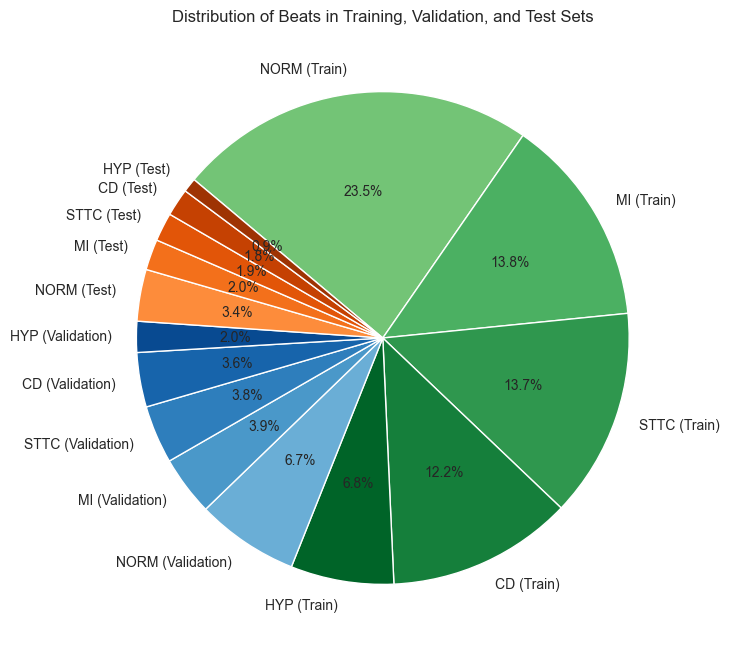

In [28]:
class_names = list(Z_train.columns)

def get_class_counts(Z_beats):
    if isinstance(Z_beats, np.ndarray):
        return Z_beats.sum(axis=0)
    else:
        return Z_beats.sum(axis=0).values

count_train = get_class_counts(Z_train_beats)
count_valid = get_class_counts(Z_valid_beats)
count_test  = get_class_counts(Z_test_beats)

total_per_class = count_train + count_valid + count_test
total_all = total_per_class.sum()
percent_per_class = 100 * total_per_class / total_all

# ---------- TABEL PRINT ----------
print("Number of Beats per Class:")
print("Class".ljust(10), "Train".rjust(10), "Valid".rjust(10), "Test".rjust(10), "%".rjust(8))
print("-" * 50)
for i, cls in enumerate(class_names):
    print(cls.ljust(10),
          str(int(count_train[i])).rjust(10),
          str(int(count_valid[i])).rjust(10),
          str(int(count_test[i])).rjust(10),
          f"{percent_per_class[i]:7.2f}%")
print("-" * 50)
print("TOTAL".ljust(10),
      str(int(count_train.sum())).rjust(10),
      str(int(count_valid.sum())).rjust(10),
      str(int(count_test.sum())).rjust(10),
      f"{100:7.2f}%")

# -------- PIE CHART --------
labels = []
sizes = []
colors = []

n_classes = len(class_names)
# Pilih shade dari colormap for tiap kelas, tiap set
train_cmap = plt.cm.Greens(np.linspace(0.5, 0.9, n_classes))
valid_cmap = plt.cm.Blues(np.linspace(0.5, 0.9, n_classes))
test_cmap  = plt.cm.Oranges(np.linspace(0.5, 0.9, n_classes))

for set_name, counts, cmap in zip(
    ['Train', 'Validation', 'Test'],
    [count_train, count_valid, count_test],
    [train_cmap, valid_cmap, test_cmap]
):
    for i, cls in enumerate(class_names):
        labels.append(f'{cls} ({set_name})')
        sizes.append(counts[i])
        colors.append(cmap[i])

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, counterclock=False)
plt.title("Distribution of Beats in Training, Validation, and Test Sets")
plt.savefig(os.path.join(folder, "Distribution of Beats in Training, Validation, and Test Sets"))
plt.show()
plt.close()

Standardization of all input datasets

Wise people sometimes recommend to normalize/standardize data before using them for modeling and predictions. I will obey their opinions.

In [22]:
# --- Fungsi normalisasi per-beat, per-lead (min-max) ---
def minmax_normalize_beats(X_beats):
    normalized_beats = []
    for beat in X_beats:
        min_val = beat.min(axis=0)
        max_val = beat.max(axis=0)
        norm_beat = (beat - min_val) / (max_val - min_val + 1e-8)
        normalized_beats.append(norm_beat)
    return np.stack(normalized_beats)

# --- Normalization ---
X_train_beats_norm = minmax_normalize_beats(X_train_beats)
X_valid_beats_norm = minmax_normalize_beats(X_valid_beats)
X_test_beats_norm  = minmax_normalize_beats(X_test_beats)

# --- Check result ---
print("Range min/max Train:", X_train_beats_norm.min(), X_train_beats_norm.max())
print("Range min/max Valid:", X_valid_beats_norm.min(), X_valid_beats_norm.max())
print("Range min/max Test :", X_test_beats_norm.min(), X_test_beats_norm.max())


Range min/max Train: 0.0 0.9999999900000002
Range min/max Valid: 0.0 0.9999999900000002
Range min/max Test : 0.0 0.9999999900000002


Pastikan bahwa hasil sudah di normalisasi

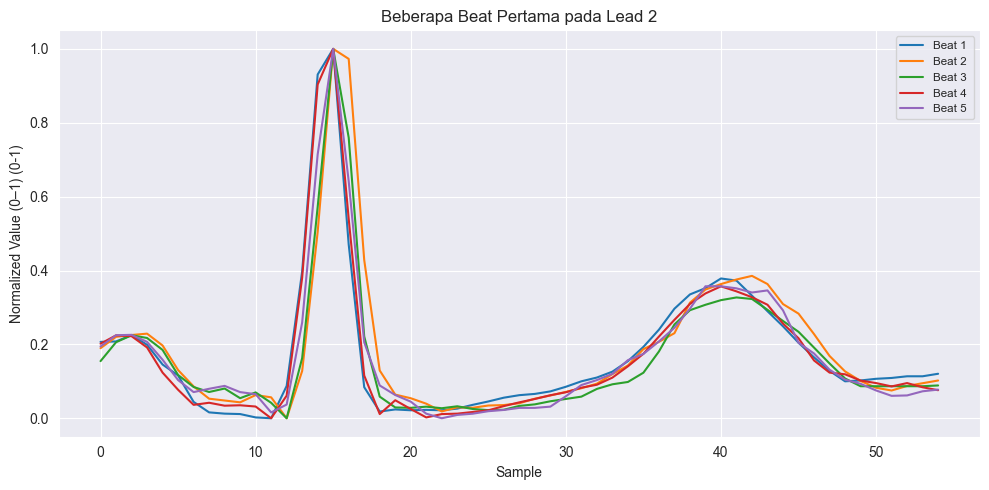

In [23]:
import matplotlib.pyplot as plt

lead_index = 1  # Change dengan indeks lead yang ingin dilihat (for example: 0 for lead 1, 1 for lead 2, dst)
n_show = 5      # Berapa beat yang ingin diDisplay

plt.figure(figsize=(10, 5))
for i in range(n_show):
    plt.plot(X_train_beats_norm[i][:, lead_index], label=f'Beat {i+1} ')

plt.title(f'Beberapa Beat Pertama pada Lead {lead_index+1}')
plt.xlabel("Sample")
plt.ylabel("Normalized Value (0–1) (0-1)")
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()


save data

In [24]:
# Create the output directory if it doesn't exist
output_dir = "data ready"
os.makedirs(output_dir, exist_ok=True)

# Save per-beat data and labels for train, validation, and test
np.savez_compressed(os.path.join(output_dir, "X_train_beats.npz"), X_train_beats=X_train_beats)
np.savez_compressed(os.path.join(output_dir, "X_valid_beats.npz"), X_valid_beats=X_valid_beats)
np.savez_compressed(os.path.join(output_dir, "X_test_beats.npz"),  X_test_beats=X_test_beats)

np.savez_compressed(os.path.join(output_dir, "Z_train_beats.npz"), Z_train_beats=Z_train_beats)
np.savez_compressed(os.path.join(output_dir, "Z_valid_beats.npz"), Z_valid_beats=Z_valid_beats)
np.savez_compressed(os.path.join(output_dir, "Z_test_beats.npz"),  Z_test_beats=Z_test_beats)

print("All per-beat data and labels have been saved to the 'data ready' folder.")

# Example of loading in another notebook:
# data = np.load('data ready/X_train_beats.npz')
# X_train_beats_loaded = data['X_train_beats']

All per-beat data and labels have been saved to the 'data ready' folder.


END of data view and preprocessing